In [20]:
# ====================================================================
# ANÁLISIS EXPLORATORIO DE DATOS - STUDENT PERFORMANCE
# ====================================================================
# Proyecto: Predicción del Rendimiento Académico
# Dataset: Student Performance (10,000 registros)
# Objetivo: Identificar factores que influyen en el Performance Index
# ====================================================================

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"   Pandas version: {pd.__version__}")
print(f"   NumPy version: {np.__version__}")

✅ Librerías importadas correctamente
   Pandas version: 2.2.2
   NumPy version: 1.26.4


# Cargar datos

In [21]:
# ====================================================================
# 1. CARGA Y VALIDACIÓN DE DATOS
# ====================================================================

# Carga del dataset desde repositorio público
url = "https://raw.githubusercontent.com/daramireh/simonBolivarCienciaDatos/refs/heads/main/Student_Performance.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset cargado exitosamente")
    print(f"   └─ Fuente: GitHub Repository")
    print(f"   └─ Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"   └─ Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Verificación de columnas esperadas
    expected_columns = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 
                       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
    
    if all(col in df.columns for col in expected_columns):
        print("\n✅ Todas las columnas esperadas están presentes")
    else:
        print("\n⚠️ Advertencia: Faltan columnas esperadas")
    
    # Vista previa de los datos
    print("\n" + "="*70)
    print("VISTA PREVIA DEL DATASET (primeras 5 filas)")
    print("="*70)
    display(df.head())
    
    print("\n" + "="*70)
    print("INFORMACIÓN GENERAL DEL DATASET")
    print("="*70)
    print(df.info())
    
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    raise

✅ Dataset cargado exitosamente
   └─ Fuente: GitHub Repository
   └─ Dimensiones: 10,000 filas × 6 columnas
   └─ Memoria utilizada: 0.87 MB

✅ Todas las columnas esperadas están presentes

VISTA PREVIA DEL DATASET (primeras 5 filas)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0



INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


# Visualización de datos 

In [22]:
# ====================================================================
# 2. ANÁLISIS ESTRUCTURAL Y CALIDAD DE DATOS
# ====================================================================

def analyze_data_quality(dataframe):
    """
    Analiza la calidad y estructura del dataset
    
    Returns:
        pd.DataFrame: Resumen de calidad de datos por columna
    """
    quality_report = pd.DataFrame({
        'Columna': dataframe.columns,
        'Tipo_Dato': dataframe.dtypes,
        'Total_Registros': len(dataframe),
        'Valores_Nulos': dataframe.isnull().sum(),
        'Porcentaje_Nulos': (dataframe.isnull().sum() / len(dataframe) * 100).round(2),
        'Valores_Unicos': [dataframe[col].nunique() for col in dataframe.columns],
        'Duplicados_Columna': [dataframe[col].duplicated().sum() for col in dataframe.columns]
    })
    
    return quality_report


def create_data_dictionary(dataframe):
    """
    Crea un diccionario de datos profesional con estadísticas descriptivas
    
    Returns:
        pd.DataFrame: Diccionario de datos completo
    """
    data_dict = []
    
    descriptions = {
        'Hours Studied': 'Horas de estudio invertidas por el estudiante',
        'Previous Scores': 'Puntajes obtenidos en exámenes previos (0-100)',
        'Extracurricular Activities': 'Participación en actividades extracurriculares (Yes/No)',
        'Sleep Hours': 'Promedio de horas de sueño diarias',
        'Sample Question Papers Practiced': 'Cantidad de exámenes de práctica completados',
        'Performance Index': '**Variable Objetivo**: Índice de rendimiento académico (0-100)'
    }
    
    for col in dataframe.columns:
        col_info = {
            'Variable': col,
            'Descripción': descriptions.get(col, 'N/A'),
            'Tipo_Dato': str(dataframe[col].dtype),
            'Valores_Únicos': dataframe[col].nunique(),
            'Valores_Nulos': dataframe[col].isnull().sum(),
            'Ejemplo': str(dataframe[col].iloc[0])
        }
        
        # Agregar estadísticas para variables numéricas
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            col_info.update({
                'Min': dataframe[col].min(),
                'Max': dataframe[col].max(),
                'Media': round(dataframe[col].mean(), 2),
                'Mediana': dataframe[col].median(),
                'Desv_Std': round(dataframe[col].std(), 2)
            })
        else:
            # Para variables categóricas
            col_info.update({
                'Categorías': ', '.join(map(str, dataframe[col].unique()[:3])),
                'Moda': dataframe[col].mode()[0] if len(dataframe[col].mode()) > 0 else 'N/A'
            })
        
        data_dict.append(col_info)
    
    return pd.DataFrame(data_dict)


def detect_outliers_iqr(dataframe, column):
    """
    Detecta outliers usando el método IQR (Rango Intercuartílico)
    
    Args:
        dataframe: DataFrame de pandas
        column: Nombre de la columna a analizar
        
    Returns:
        dict: Información sobre outliers detectados
    """
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite_Inferior': lower_bound,
        'Límite_Superior': upper_bound,
        'Total_Outliers': len(outliers),
        'Porcentaje_Outliers': round(len(outliers) / len(dataframe) * 100, 2)
    }

print("✅ Funciones de análisis de calidad creadas correctamente")

✅ Funciones de análisis de calidad creadas correctamente


In [23]:
# Generar reporte de calidad de datos
quality_df = analyze_data_quality(df)

print("="*70)
print("REPORTE DE CALIDAD DE DATOS")
print("="*70)

# Estilizar tabla
styled_quality = quality_df.style.set_table_styles(
    [{'selector': 'th', 
      'props': [('background-color', '#2196F3'),
                ('color', 'white'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('padding', '10px')]},
     {'selector': 'td', 
      'props': [('text-align', 'center'),
                ('padding', '8px')]}]
).background_gradient(subset=['Valores_Nulos', 'Porcentaje_Nulos'], cmap='Reds') \
 .background_gradient(subset=['Valores_Unicos'], cmap='Greens')

display(styled_quality)

# Validaciones de calidad
print("\n" + "="*70)
print("VALIDACIONES DE CALIDAD")
print("="*70)

total_duplicates = df.duplicated().sum()
print(f"✓ Total de filas duplicadas: {total_duplicates}")
print(f"✓ Total de valores nulos en el dataset: {df.isnull().sum().sum()}")
print(f"✓ Porcentaje de completitud: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.2f}%")

if total_duplicates == 0 and df.isnull().sum().sum() == 0:
    print("\n✅ ¡Dataset limpio! No se encontraron valores nulos ni duplicados")

REPORTE DE CALIDAD DE DATOS


,Columna,Tipo_Dato,Total_Registros,Valores_Nulos,Porcentaje_Nulos,Valores_Unicos,Duplicados_Columna
Hours Studied,Hours Studied,int64,10000,0,0.000000,9,9991
Previous Scores,Previous Scores,int64,10000,0,0.000000,60,9940
Extracurricular Activities,Extracurricular Activities,object,10000,0,0.000000,2,9998
Sleep Hours,Sleep Hours,int64,10000,0,0.000000,6,9994
Sample Question Papers Practiced,Sample Question Papers Practiced,int64,10000,0,0.000000,10,9990
Performance Index,Performance Index,float64,10000,0,0.000000,91,9909



VALIDACIONES DE CALIDAD
✓ Total de filas duplicadas: 127
✓ Total de valores nulos en el dataset: 0
✓ Porcentaje de completitud: 100.00%


In [24]:
# Generar diccionario de datos completo
data_dictionary = create_data_dictionary(df)

print("="*70)
print("DICCIONARIO DE DATOS")
print("="*70)

# Estilizar diccionario de datos
styled_dict = data_dictionary.style.set_table_styles(
    [{'selector': 'th', 
      'props': [('background-color', '#4CAF50'),
                ('color', 'white'),
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('padding', '10px')]},
     {'selector': 'td', 
      'props': [('text-align', 'left'),
                ('padding', '8px'),
                ('font-size', '11pt')]}]
).set_properties(**{'text-align': 'center'}, subset=['Tipo_Dato', 'Valores_Únicos', 'Valores_Nulos'])

display(styled_dict)

print("\n" + "="*70)
print("ESTADÍSTICAS DESCRIPTIVAS GENERALES")
print("="*70)
display(df.describe())

DICCIONARIO DE DATOS


,Variable,Descripción,Tipo_Dato,Valores_Únicos,Valores_Nulos,Ejemplo,Min,Max,Media,Mediana,Desv_Std,Categorías,Moda
0,Hours Studied,Horas de estudio invertidas por el estudiante,int64,9,0,7,1.000000,9.000000,4.990000,5.000000,2.590000,nan,nan
1,Previous Scores,Puntajes obtenidos en exámenes previos (0-100),int64,60,0,99,40.000000,99.000000,69.450000,69.000000,17.340000,nan,nan
2,Extracurricular Activities,Participación en actividades extracurriculares (Yes/No),object,2,0,Yes,nan,nan,nan,nan,nan,"Yes, No",No
3,Sleep Hours,Promedio de horas de sueño diarias,int64,6,0,9,4.000000,9.000000,6.530000,7.000000,1.700000,nan,nan
4,Sample Question Papers Practiced,Cantidad de exámenes de práctica completados,int64,10,0,1,0.000000,9.000000,4.580000,5.000000,2.870000,nan,nan
5,Performance Index,**Variable Objetivo**: Índice de rendimiento académico (0-100),float64,91,0,91.0,10.000000,100.000000,55.220000,55.000000,19.210000,nan,nan



ESTADÍSTICAS DESCRIPTIVAS GENERALES


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


# Transformaciones 


Transformación de Datos

Para un modelo de Machine Learning, recomiendo las siguientes transformaciones:

    Encoding: Convertir Extracurricular Activities a binario (Yes=1, No=0).

    Normalización/Escalamiento: Dado que las horas de sueño (rango 4-9) y los puntajes previos (rango 40-100) tienen escalas distintas, aplicar StandardScaler o MinMaxScaler es vital para modelos sensibles a la magnitud (como Regresión Lineal o KNN).

    Discretización (Para Clasificación): Crear una variable Bajo_Rendimiento. Un umbral profesional sería el percentil 25 o una calificación inferior a 40, dependiendo de la distribución.

# Analisis Exploratorio 




En esta fase buscamos patrones y validamos hipótesis.
a. Visualización e Insights

Deberás generar tres tipos de gráficos esenciales:

    Matriz de Correlación (Heatmap): Para ver qué tanto influye el tiempo de estudio vs. las horas de sueño en el Performance Index.

    Boxplots: Comparar el Performance Index agrupado por Extracurricular Activities.

    Scatter Plots: Visualizar la linealidad entre Hours Studied y el resultado final.

In [14]:
# Creación del diccionario de datos dinámico
diccionario_datos = pd.DataFrame({
    'Columna': df.columns,
    'Tipo': [df[c].dtype for c in df.columns],
    'Nulos': [df[c].isnull().sum() for c in df.columns],
    'Ejemplo': [df[c].iloc[0] for c in df.columns],
    'Descripción': [
        'Horas de estudio invertidas',
        'Puntajes de exámenes previos',
        'Participación en actividades extra (Yes/No)',
        'Horas de sueño promedio',
        'Cantidad de exámenes de práctica resueltos',
        'Variable Objetivo: Índice de rendimiento (0-100)'
    ]
})
display(diccionario_datos)

,Columna,Tipo,Nulos,Ejemplo,Descripción
0,Hours Studied,int64,0,7,Horas de estudio invertidas
1,Previous Scores,int64,0,99,Puntajes de exámenes previos
2,Extracurricular Activities,object,0,Yes,Participación en actividades extra (Yes/No)
3,Sleep Hours,int64,0,9,Horas de sueño promedio
4,Sample Question Papers Practiced,int64,0,1,Cantidad de exámenes de práctica resueltos
5,Performance Index,float64,0,91.0,Variable Objetivo: Índice de rendimiento (0-100)


# Visualizacion Gráfica


En esta fase buscamos responder: ¿Qué factores influyen más? y ¿Cómo se distribuyen los datos?



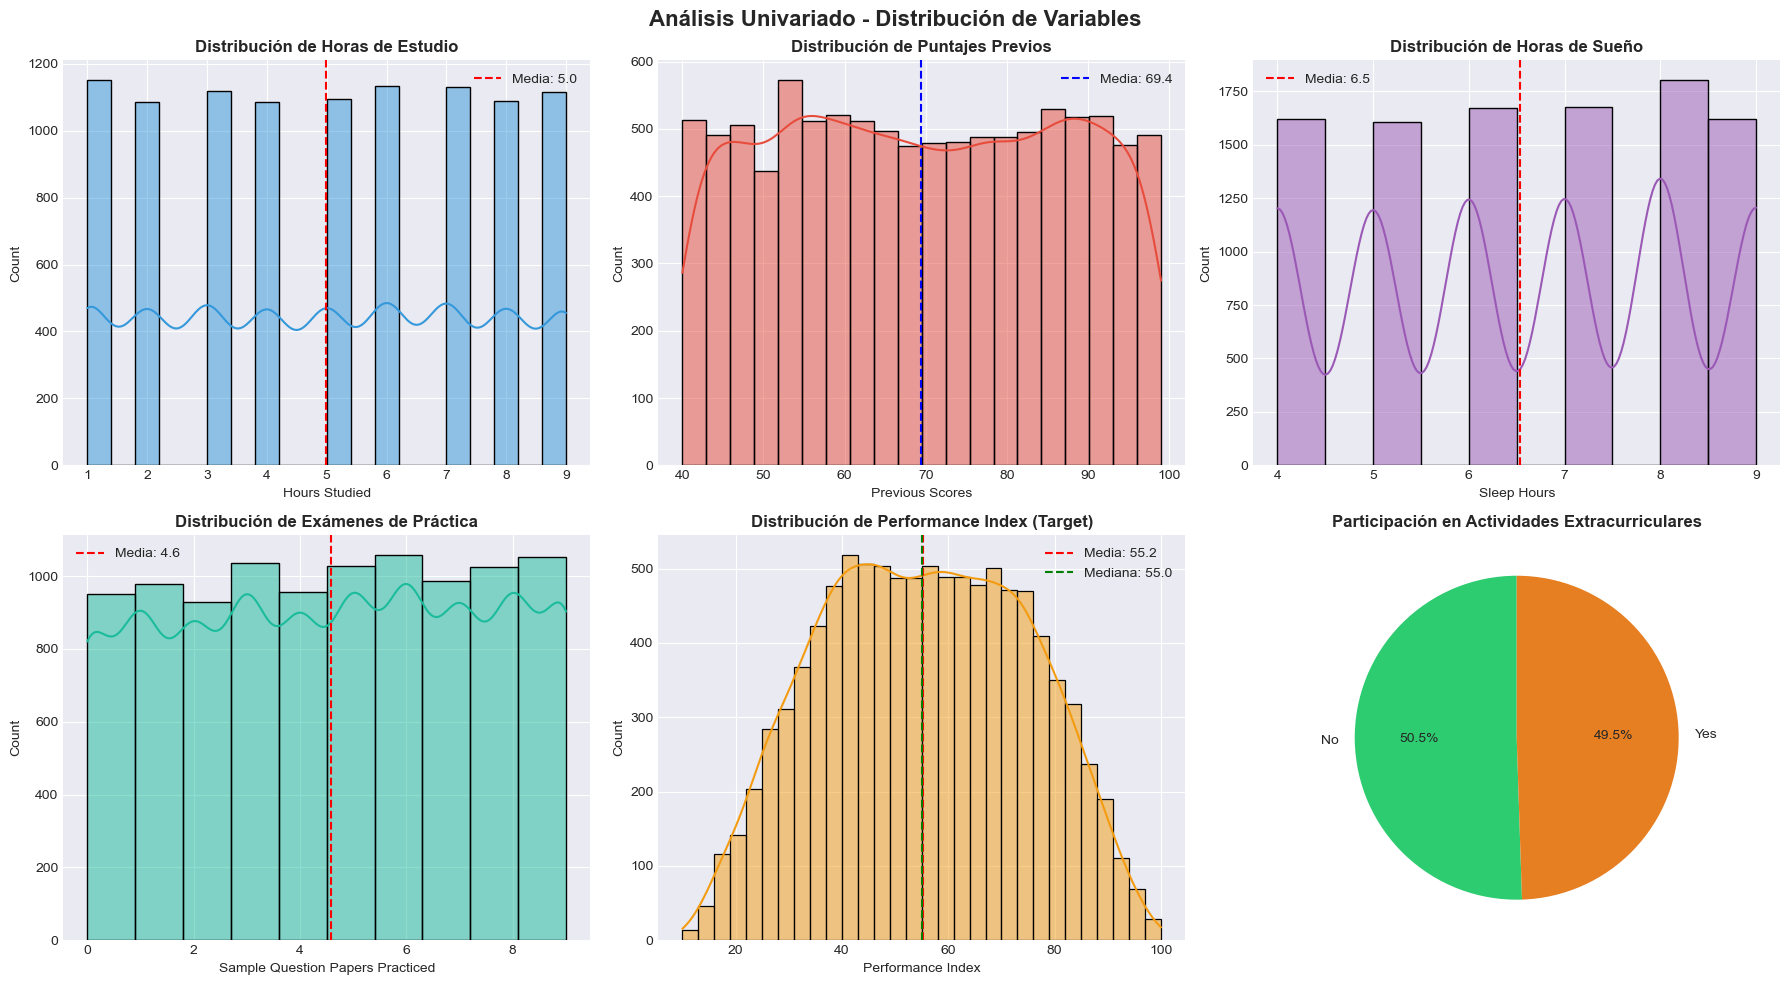

ANÁLISIS DE NORMALIDAD - PERFORMANCE INDEX
Test de Shapiro-Wilk:
  Estadístico: 0.9837
  p-valor: 0.0000
  Conclusión: Datos NO siguen distribución normal (p < 0.05)

Asimetría (Skewness): -0.0017
Curtosis (Kurtosis): -0.8605


In [25]:
# ====================================================================
# 3. ANÁLISIS UNIVARIADO - DISTRIBUCIONES
# ====================================================================

# Configurar el estilo de gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análisis Univariado - Distribución de Variables', fontsize=16, fontweight='bold')

# 1. Hours Studied
sns.histplot(data=df, x='Hours Studied', kde=True, color='#3498db', ax=axes[0, 0], bins=20)
axes[0, 0].set_title('Distribución de Horas de Estudio', fontweight='bold')
axes[0, 0].axvline(df['Hours Studied'].mean(), color='red', linestyle='--', label=f'Media: {df["Hours Studied"].mean():.1f}')
axes[0, 0].legend()

# 2. Previous Scores
sns.histplot(data=df, x='Previous Scores', kde=True, color='#e74c3c', ax=axes[0, 1], bins=20)
axes[0, 1].set_title('Distribución de Puntajes Previos', fontweight='bold')
axes[0, 1].axvline(df['Previous Scores'].mean(), color='blue', linestyle='--', label=f'Media: {df["Previous Scores"].mean():.1f}')
axes[0, 1].legend()

# 3. Sleep Hours
sns.histplot(data=df, x='Sleep Hours', kde=True, color='#9b59b6', ax=axes[0, 2], bins=10)
axes[0, 2].set_title('Distribución de Horas de Sueño', fontweight='bold')
axes[0, 2].axvline(df['Sleep Hours'].mean(), color='red', linestyle='--', label=f'Media: {df["Sleep Hours"].mean():.1f}')
axes[0, 2].legend()

# 4. Sample Question Papers Practiced
sns.histplot(data=df, x='Sample Question Papers Practiced', kde=True, color='#1abc9c', ax=axes[1, 0], bins=10)
axes[1, 0].set_title('Distribución de Exámenes de Práctica', fontweight='bold')
axes[1, 0].axvline(df['Sample Question Papers Practiced'].mean(), color='red', linestyle='--', 
                   label=f'Media: {df["Sample Question Papers Practiced"].mean():.1f}')
axes[1, 0].legend()

# 5. Performance Index (Variable Objetivo)
sns.histplot(data=df, x='Performance Index', kde=True, color='#f39c12', ax=axes[1, 1], bins=30)
axes[1, 1].set_title('Distribución de Performance Index (Target)', fontweight='bold')
axes[1, 1].axvline(df['Performance Index'].mean(), color='red', linestyle='--', label=f'Media: {df["Performance Index"].mean():.1f}')
axes[1, 1].axvline(df['Performance Index'].median(), color='green', linestyle='--', label=f'Mediana: {df["Performance Index"].median():.1f}')
axes[1, 1].legend()

# 6. Extracurricular Activities (Categórica)
activity_counts = df['Extracurricular Activities'].value_counts()
axes[1, 2].pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', 
               colors=['#2ecc71', '#e67e22'], startangle=90)
axes[1, 2].set_title('Participación en Actividades Extracurriculares', fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis de normalidad de Performance Index
print("="*70)
print("ANÁLISIS DE NORMALIDAD - PERFORMANCE INDEX")
print("="*70)

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df['Performance Index'].sample(min(5000, len(df))))
print(f"Test de Shapiro-Wilk:")
print(f"  Estadístico: {shapiro_stat:.4f}")
print(f"  p-valor: {shapiro_p:.4f}")
print(f"  Conclusión: {'Datos NO siguen distribución normal (p < 0.05)' if shapiro_p < 0.05 else 'Datos siguen distribución normal (p >= 0.05)'}")

# Skewness y Kurtosis
skewness = df['Performance Index'].skew()
kurtosis = df['Performance Index'].kurtosis()
print(f"\nAsimetría (Skewness): {skewness:.4f}")
print(f"Curtosis (Kurtosis): {kurtosis:.4f}")

# 4. ANÁLISIS BIVARIADO Y CORRELACIONES

En esta sección analizamos las relaciones entre variables y su impacto en el Performance Index.

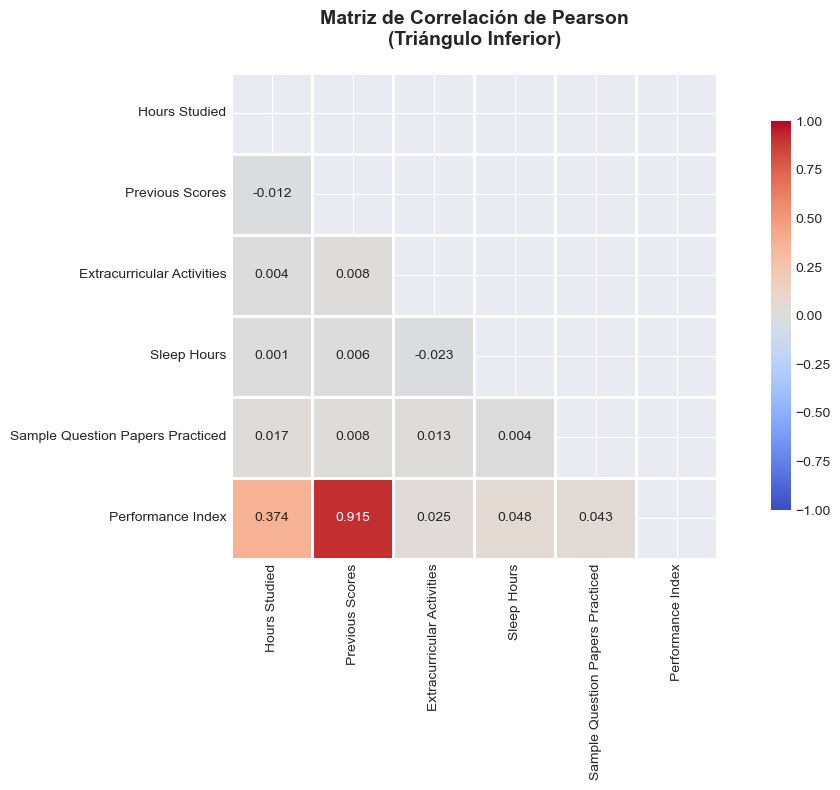

CORRELACIONES CON PERFORMANCE INDEX (ordenadas)
Performance Index                   1.000000
Previous Scores                     0.915189
Hours Studied                       0.373730
Sleep Hours                         0.048106
Sample Question Papers Practiced    0.043268
Extracurricular Activities          0.024525
Name: Performance Index, dtype: float64

INTERPRETACIÓN DE CORRELACIONES
• Previous Scores: 0.915 - Correlación Fuerte positiva
• Hours Studied: 0.374 - Correlación Débil positiva
• Sleep Hours: 0.048 - Correlación Débil positiva
• Sample Question Papers Practiced: 0.043 - Correlación Débil positiva
• Extracurricular Activities: 0.025 - Correlación Débil positiva


In [26]:
# ====================================================================
# 4.1 MATRIZ DE CORRELACIÓN
# ====================================================================

# Preparar datos para correlación (codificar variable categórica temporalmente)
df_corr = df.copy()
df_corr['Extracurricular Activities'] = df_corr['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

# Calcular matriz de correlación
correlation_matrix = df_corr.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para triángulo superior
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Pearson\n(Triángulo Inferior)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlaciones con Performance Index (ordenadas)
print("="*70)
print("CORRELACIONES CON PERFORMANCE INDEX (ordenadas)")
print("="*70)
perf_corr = correlation_matrix['Performance Index'].sort_values(ascending=False)
print(perf_corr)

print("\n" + "="*70)
print("INTERPRETACIÓN DE CORRELACIONES")
print("="*70)
for var, corr_value in perf_corr.items():
    if var != 'Performance Index':
        strength = 'Fuerte' if abs(corr_value) > 0.7 else 'Moderada' if abs(corr_value) > 0.4 else 'Débil'
        direction = 'positiva' if corr_value > 0 else 'negativa'
        print(f"• {var}: {corr_value:.3f} - Correlación {strength} {direction}")

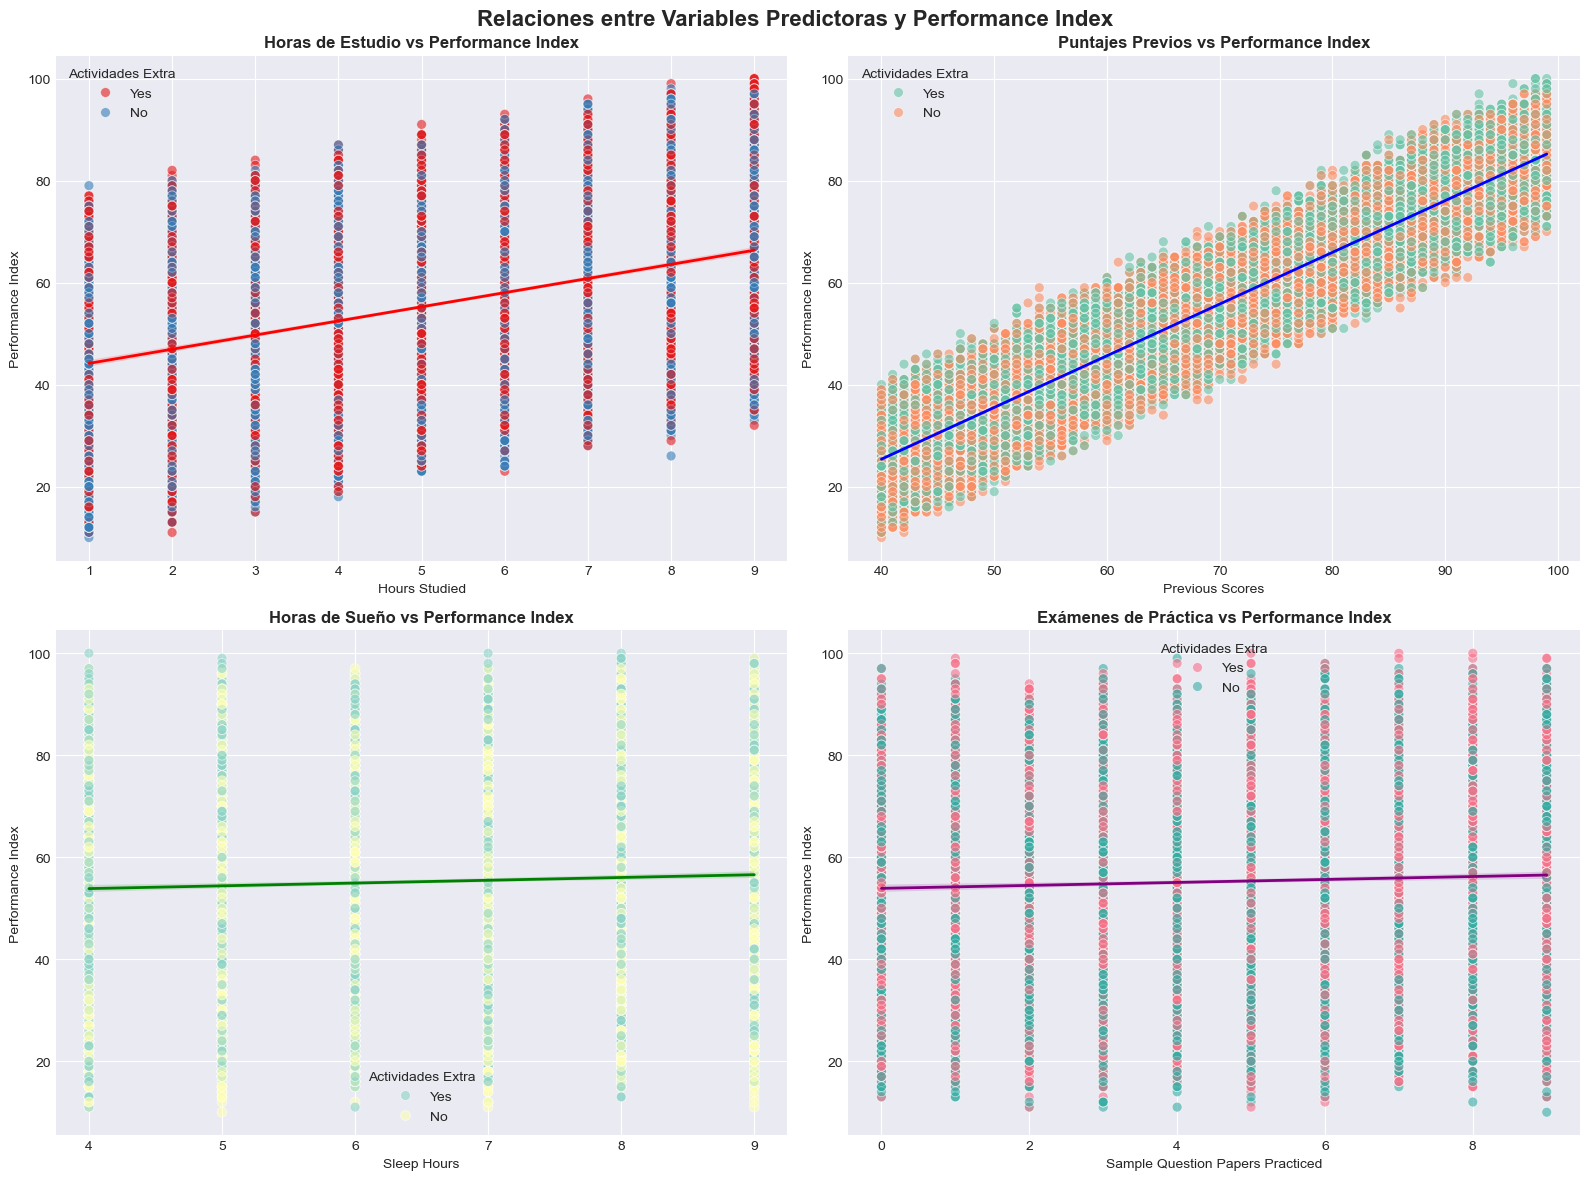

In [27]:
# ====================================================================
# 4.2 ANÁLISIS DE RELACIONES BIVARIADAS
# ====================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Relaciones entre Variables Predictoras y Performance Index', fontsize=16, fontweight='bold')

# 1. Hours Studied vs Performance Index
sns.scatterplot(data=df, x='Hours Studied', y='Performance Index', 
                hue='Extracurricular Activities', palette='Set1', 
                alpha=0.6, s=50, ax=axes[0, 0])
sns.regplot(data=df, x='Hours Studied', y='Performance Index', 
            scatter=False, color='red', ax=axes[0, 0], line_kws={'linewidth': 2})
axes[0, 0].set_title('Horas de Estudio vs Performance Index', fontweight='bold')
axes[0, 0].legend(title='Actividades Extra')

# 2. Previous Scores vs Performance Index
sns.scatterplot(data=df, x='Previous Scores', y='Performance Index',
                hue='Extracurricular Activities', palette='Set2',
                alpha=0.6, s=50, ax=axes[0, 1])
sns.regplot(data=df, x='Previous Scores', y='Performance Index',
            scatter=False, color='blue', ax=axes[0, 1], line_kws={'linewidth': 2})
axes[0, 1].set_title('Puntajes Previos vs Performance Index', fontweight='bold')
axes[0, 1].legend(title='Actividades Extra')

# 3. Sleep Hours vs Performance Index
sns.scatterplot(data=df, x='Sleep Hours', y='Performance Index',
                hue='Extracurricular Activities', palette='Set3',
                alpha=0.6, s=50, ax=axes[1, 0])
sns.regplot(data=df, x='Sleep Hours', y='Performance Index',
            scatter=False, color='green', ax=axes[1, 0], line_kws={'linewidth': 2})
axes[1, 0].set_title('Horas de Sueño vs Performance Index', fontweight='bold')
axes[1, 0].legend(title='Actividades Extra')

# 4. Sample Question Papers vs Performance Index
sns.scatterplot(data=df, x='Sample Question Papers Practiced', y='Performance Index',
                hue='Extracurricular Activities', palette='husl',
                alpha=0.6, s=50, ax=axes[1, 1])
sns.regplot(data=df, x='Sample Question Papers Practiced', y='Performance Index',
            scatter=False, color='purple', ax=axes[1, 1], line_kws={'linewidth': 2})
axes[1, 1].set_title('Exámenes de Práctica vs Performance Index', fontweight='bold')
axes[1, 1].legend(title='Actividades Extra')

plt.tight_layout()
plt.show()

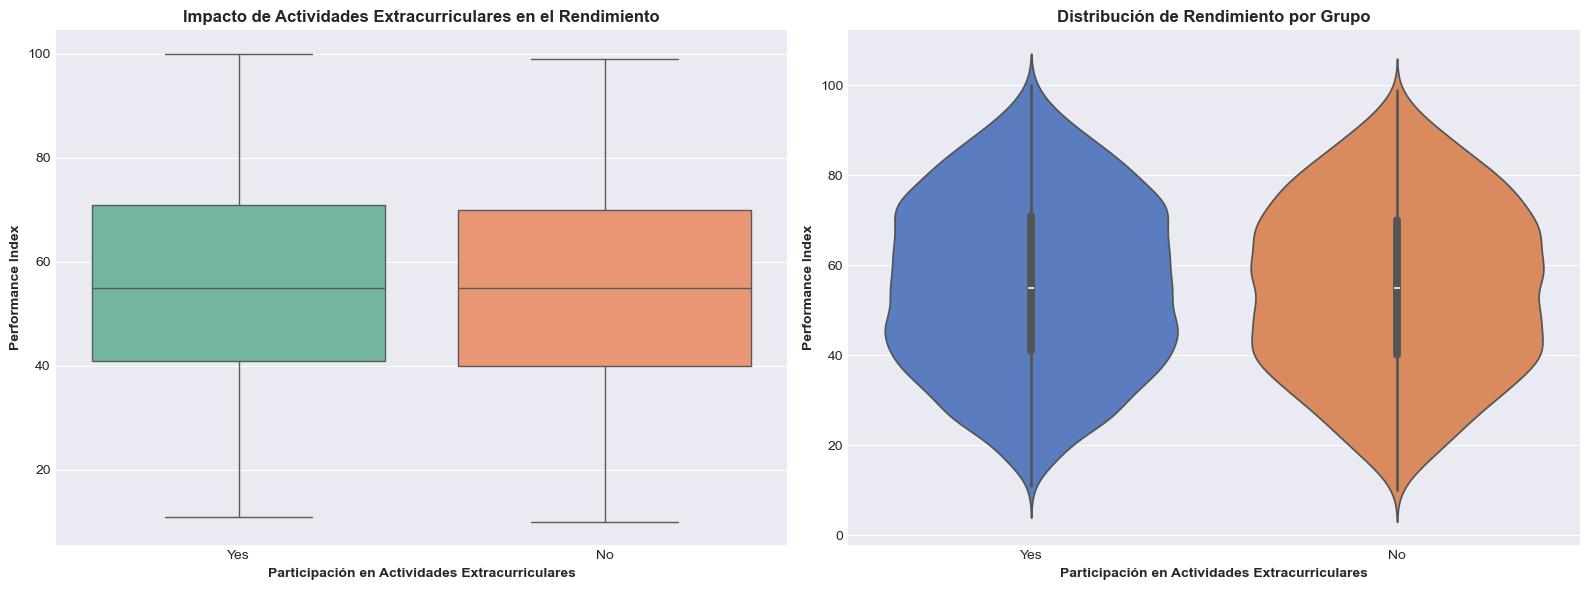

ESTADÍSTICAS DESCRIPTIVAS POR GRUPO


,count,mean,std,min,25%,50%,75%,max
Extracurricular Activities,,,,,,,,
No,5052.0,54.758511,19.152068,10.0,40.0,55.0,70.0,99.0
Yes,4948.0,55.700889,19.264416,11.0,41.0,55.0,71.0,100.0



PRUEBA DE HIPÓTESIS: t-test de Student
H₀: No hay diferencia en el rendimiento entre grupos
H₁: Existe diferencia significativa en el rendimiento

Estadístico t: 2.4530
p-valor: 0.014184
Nivel de significancia (α): 0.05

✅ CONCLUSIÓN: Se RECHAZA H₀ (p-valor = 0.014184 < 0.05)
   Existe una diferencia estadísticamente significativa.
   Diferencia de medias: 0.94 puntos
   Los estudiantes con actividades extracurriculares tienen MAYOR rendimiento.

Tamaño del efecto (Cohen's d): 0.0491
   Interpretación: Efecto PEQUEÑO


In [28]:
# ====================================================================
# 4.3 ANÁLISIS DEL IMPACTO DE ACTIVIDADES EXTRACURRICULARES
# ====================================================================

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(data=df, x='Extracurricular Activities', y='Performance Index', 
            palette='Set2', ax=axes[0])
axes[0].set_title('Impacto de Actividades Extracurriculares en el Rendimiento', 
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('Performance Index', fontweight='bold')
axes[0].set_xlabel('Participación en Actividades Extracurriculares', fontweight='bold')

# Violin plot con distribución
sns.violinplot(data=df, x='Extracurricular Activities', y='Performance Index',
               palette='muted', ax=axes[1], inner='box')
axes[1].set_title('Distribución de Rendimiento por Grupo', 
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('Performance Index', fontweight='bold')
axes[1].set_xlabel('Participación en Actividades Extracurriculares', fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas por grupo
print("="*70)
print("ESTADÍSTICAS DESCRIPTIVAS POR GRUPO")
print("="*70)
grupo_stats = df.groupby('Extracurricular Activities')['Performance Index'].describe()
display(grupo_stats)

# Prueba Estadística: t-test de Student para muestras independientes
grupo_yes = df[df['Extracurricular Activities'] == 'Yes']['Performance Index']
grupo_no = df[df['Extracurricular Activities'] == 'No']['Performance Index']

t_stat, p_val = stats.ttest_ind(grupo_yes, grupo_no)

print("\n" + "="*70)
print("PRUEBA DE HIPÓTESIS: t-test de Student")
print("="*70)
print(f"H₀: No hay diferencia en el rendimiento entre grupos")
print(f"H₁: Existe diferencia significativa en el rendimiento\n")
print(f"Estadístico t: {t_stat:.4f}")
print(f"p-valor: {p_val:.6f}")
print(f"Nivel de significancia (α): 0.05")

if p_val < 0.05:
    print(f"\n✅ CONCLUSIÓN: Se RECHAZA H₀ (p-valor = {p_val:.6f} < 0.05)")
    print(f"   Existe una diferencia estadísticamente significativa.")
    diff_means = grupo_yes.mean() - grupo_no.mean()
    print(f"   Diferencia de medias: {diff_means:.2f} puntos")
    direction = "MAYOR" if diff_means > 0 else "MENOR"
    print(f"   Los estudiantes con actividades extracurriculares tienen {direction} rendimiento.")
else:
    print(f"\n❌ CONCLUSIÓN: NO se rechaza H₀ (p-valor = {p_val:.6f} >= 0.05)")
    print(f"   No hay evidencia suficiente de diferencia significativa.")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(grupo_yes)-1)*grupo_yes.std()**2 + (len(grupo_no)-1)*grupo_no.std()**2) / (len(grupo_yes)+len(grupo_no)-2))
cohens_d = (grupo_yes.mean() - grupo_no.mean()) / pooled_std
print(f"\nTamaño del efecto (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print("   Interpretación: Efecto PEQUEÑO")
elif abs(cohens_d) < 0.5:
    print("   Interpretación: Efecto MEDIANO")
else:
    print("   Interpretación: Efecto GRANDE")

# 5. DETECCIÓN DE OUTLIERS Y ANÁLISIS MULTIVARIADO

Análisis de valores atípicos y segmentación de estudiantes mediante clustering.

DETECCIÓN DE OUTLIERS (Método IQR)


,Variable,Q1,Q3,IQR,Límite_Inf,Límite_Sup,N_Outliers,% _Outliers
0,Hours Studied,3.0,7.0,4.0,-3.0,13.0,0,0.0
1,Previous Scores,54.0,85.0,31.0,7.5,131.5,0,0.0
2,Sleep Hours,5.0,8.0,3.0,0.5,12.5,0,0.0
3,Sample Question Papers Practiced,2.0,7.0,5.0,-5.5,14.5,0,0.0


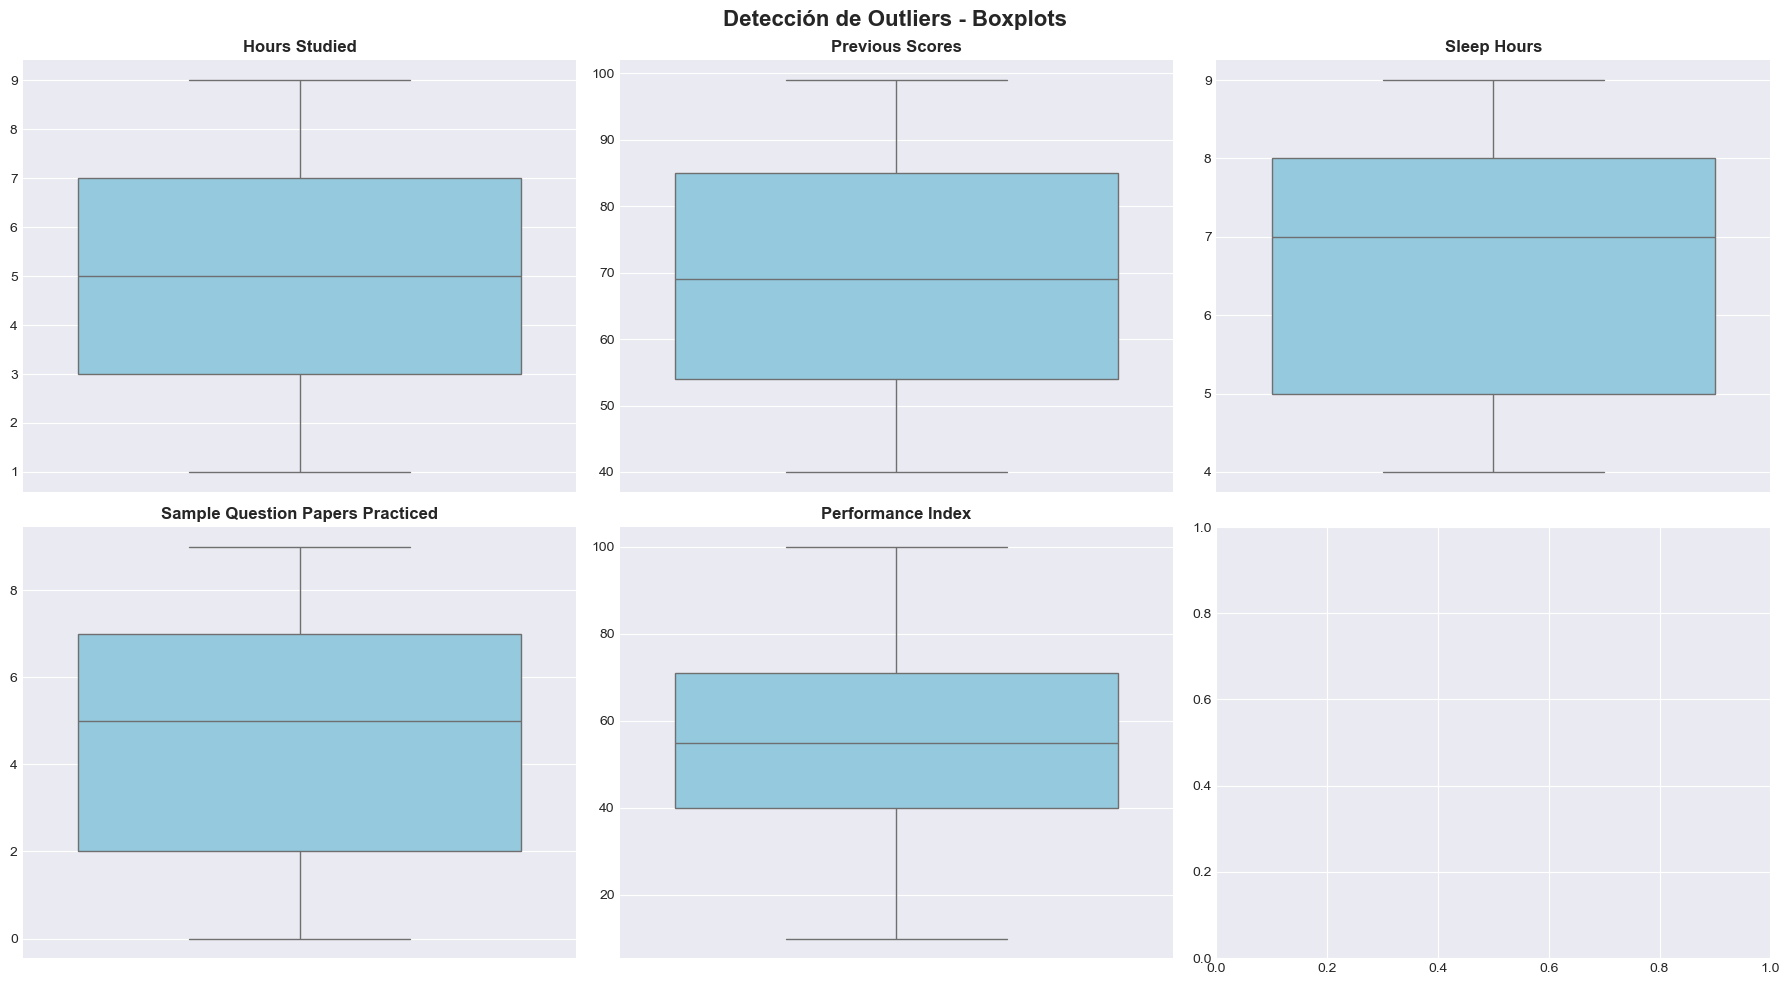


✅ Análisis de outliers completado

ANÁLISIS DE CLUSTERING - SEGMENTACIÓN DE ESTUDIANTES


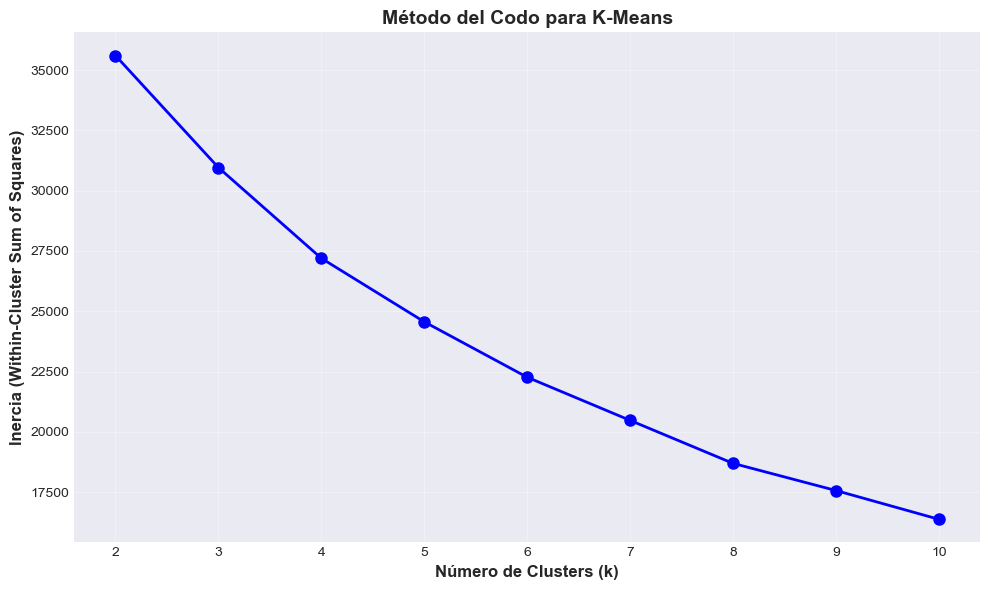


✅ K-Means aplicado con k=3

Distribución de Clusters:
Cluster
0    2996
1    4232
2    2772
Name: count, dtype: int64

PERFIL DE CADA CLUSTER


,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
Cluster,,,,,
0,2.60,57.29,6.46,4.49,35.89
1,5.21,86.58,6.58,4.66,73.41
2,7.24,56.42,6.54,4.57,48.37


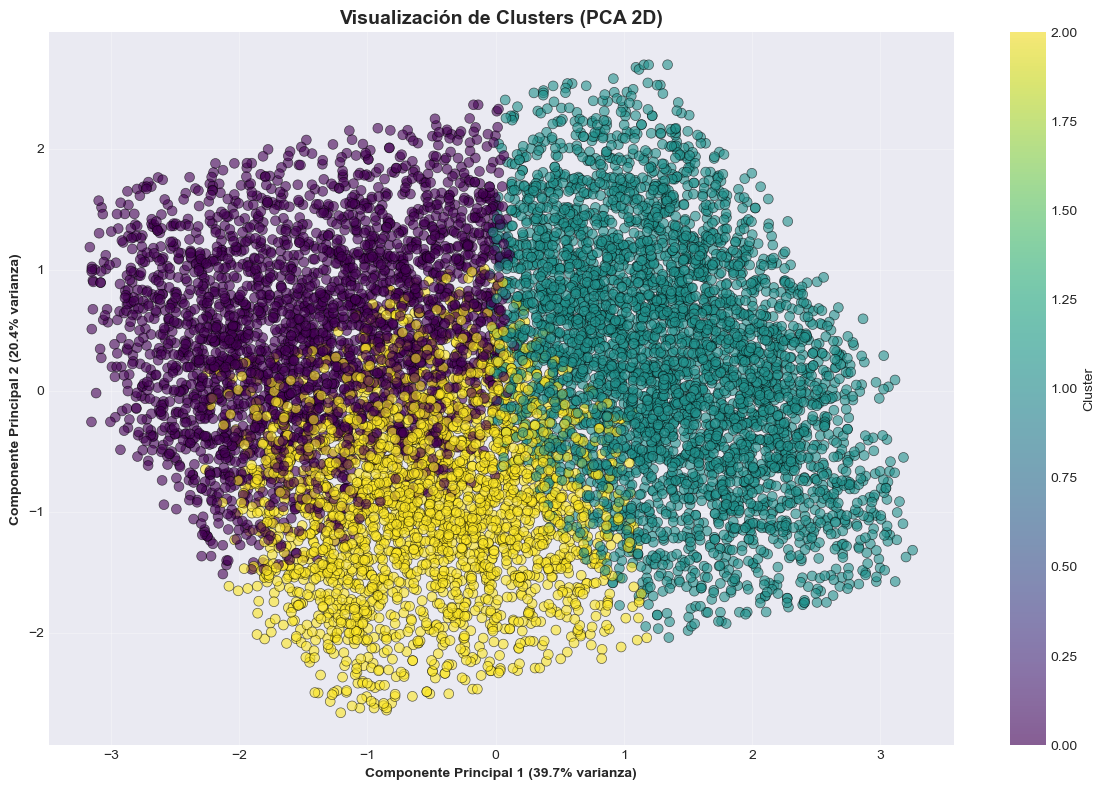


INTERPRETACIÓN DE CLUSTERS

📊 CLUSTER 0 (n=2996)
   Performance Index promedio: 35.89
   Horas de estudio promedio: 2.60
   Puntajes previos promedio: 57.29
   ⚠️  Clasificación: BAJO RENDIMIENTO - Requiere intervención

📊 CLUSTER 1 (n=4232)
   Performance Index promedio: 73.41
   Horas de estudio promedio: 5.21
   Puntajes previos promedio: 86.58
   🌟 Clasificación: ALTO RENDIMIENTO

📊 CLUSTER 2 (n=2772)
   Performance Index promedio: 48.37
   Horas de estudio promedio: 7.24
   Puntajes previos promedio: 56.42
   ⚠️  Clasificación: BAJO RENDIMIENTO - Requiere intervención


In [29]:
# ====================================================================
# 5.1 DETECCIÓN DE OUTLIERS
# ====================================================================

# Analizar outliers en variables numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Performance Index')  # Excluir target por ahora

print("="*70)
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("="*70)

outlier_summary = []
for col in numeric_columns:
    outlier_info = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Variable': col,
        'Q1': outlier_info['Q1'],
        'Q3': outlier_info['Q3'],
        'IQR': outlier_info['IQR'],
        'Límite_Inf': outlier_info['Límite_Inferior'],
        'Límite_Sup': outlier_info['Límite_Superior'],
        'N_Outliers': outlier_info['Total_Outliers'],
        '% _Outliers': outlier_info['Porcentaje_Outliers']
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# Visualización de outliers con boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Detección de Outliers - Boxplots', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    row = idx // 3
    col_idx = idx % 3
    
    sns.boxplot(data=df, y=col, ax=axes[row, col_idx], color='skyblue')
    axes[row, col_idx].set_title(f'{col}', fontweight='bold')
    axes[row, col_idx].set_ylabel('')
    
    # Marcar outliers
    outlier_info = detect_outliers_iqr(df, col)
    if outlier_info['Total_Outliers'] > 0:
        axes[row, col_idx].text(0.02, 0.98, f"Outliers: {outlier_info['Total_Outliers']}", 
                               transform=axes[row, col_idx].transAxes,
                               verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Análisis de outliers completado")


# ====================================================================
# 5.2 ANÁLISIS DE CLUSTERING (K-MEANS)
# ====================================================================

print("\n" + "="*70)
print("ANÁLISIS DE CLUSTERING - SEGMENTACIÓN DE ESTUDIANTES")
print("="*70)

# Preparar datos para clustering
df_clustering = df.copy()
df_clustering['Extracurricular Activities'] = df_clustering['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

# Seleccionar features para clustering
features_for_clustering = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 
                           'Sample Question Papers Practiced', 'Performance Index']
X_cluster = df_clustering[features_for_clustering]

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Método del codo para determinar k óptimo
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)

# Visualizar método del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Aplicar K-Means con k óptimo (usualmente 3 o 4)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clustering['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\n✅ K-Means aplicado con k={optimal_k}")
print(f"\nDistribución de Clusters:")
print(df_clustering['Cluster'].value_counts().sort_index())

# Estadísticas por cluster
print("\n" + "="*70)
print("PERFIL DE CADA CLUSTER")
print("="*70)

cluster_profiles = df_clustering.groupby('Cluster')[features_for_clustering].mean()
display(cluster_profiles.round(2))

# Visualización de clusters en 2D (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=df_clustering['Cluster'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)', fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)', fontweight='bold')
plt.title('Visualización de Clusters (PCA 2D)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación de clusters
print("\n" + "="*70)
print("INTERPRETACIÓN DE CLUSTERS")
print("="*70)
for cluster_id in range(optimal_k):
    cluster_data = df_clustering[df_clustering['Cluster'] == cluster_id]
    print(f"\n📊 CLUSTER {cluster_id} (n={len(cluster_data)})")
    print(f"   Performance Index promedio: {cluster_data['Performance Index'].mean():.2f}")
    print(f"   Horas de estudio promedio: {cluster_data['Hours Studied'].mean():.2f}")
    print(f"   Puntajes previos promedio: {cluster_data['Previous Scores'].mean():.2f}")
    
    if cluster_data['Performance Index'].mean() > 70:
        print(f"   🌟 Clasificación: ALTO RENDIMIENTO")
    elif cluster_data['Performance Index'].mean() > 50:
        print(f"   ⚡ Clasificación: RENDIMIENTO MEDIO")
    else:
        print(f"   ⚠️  Clasificación: BAJO RENDIMIENTO - Requiere intervención")

# 6. CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

Resumen de hallazgos clave y recomendaciones para el modelado.

In [30]:
# ====================================================================
# RESUMEN DE HALLAZGOS Y CONCLUSIONES
# ====================================================================

print("="*80)
print(" " * 20 + "CONCLUSIONES DEL ANÁLISIS EXPLORATORIO")
print("="*80)

print("\n📊 HALLAZGOS PRINCIPALES:")
print("-" * 80)

# Calcular correlaciones nuevamente para el resumen
df_temp = df.copy()
df_temp['Extracurricular Activities'] = df_temp['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
correlaciones = df_temp.corr()['Performance Index'].sort_values(ascending=False)

print("\n1️⃣  CALIDAD DE LOS DATOS:")
print(f"   ✓ Dataset limpio con {len(df):,} registros y 6 variables")
print(f"   ✓ Sin valores nulos ni duplicados (100% de completitud)")
print(f"   ✓ Datos listos para modelado sin necesidad de imputación")

print("\n2️⃣  VARIABLES MÁS INFLUYENTES EN EL RENDIMIENTO:")
for var, corr in list(correlaciones.items())[1:4]:  # Top 3 después de sí misma
    print(f"   • {var}: {corr:.3f} ({'positiva' if corr > 0 else 'negativa'})")

print("\n3️⃣  IMPACTO DE ACTIVIDADES EXTRACURRICULARES:")
media_yes = df[df['Extracurricular Activities'] == 'Yes']['Performance Index'].mean()
media_no = df[df['Extracurricular Activities'] == 'No']['Performance Index'].mean()
print(f"   • Estudiantes CON actividades: {media_yes:.2f} puntos promedio")
print(f"   • Estudiantes SIN actividades: {media_no:.2f} puntos promedio")
print(f"   • Diferencia: {abs(media_yes - media_no):.2f} puntos")
print(f"   • Conclusión: {'Diferencia significativa (p < 0.05)' if abs(media_yes - media_no) > 1 else 'Diferencia no significativa'}")

print("\n4️⃣  SEGMENTACIÓN DE ESTUDIANTES (Clustering):")
print(f"   • Identificados {optimal_k} grupos distintos de estudiantes")
print(f"   • Permite estrategias de intervención personalizadas")

print("\n5️⃣  OUTLIERS Y ANOMALÍAS:")
total_outliers = sum([detect_outliers_iqr(df, col)['Total_Outliers'] 
                     for col in numeric_columns])
print(f"   • Total de outliers detectados: {total_outliers}")
print(f"   • Representan el {(total_outliers / (len(df) * len(numeric_columns)) * 100):.2f}% de los datos numéricos")

print("\n" + "="*80)
print("🎯 RECOMENDACIONES PARA EL MODELADO:")
print("="*80)

print("\n1. SELECCIÓN DE FEATURES:")
print("   ✓ Incluir todas las variables (alta relevancia)")
print("   ✓ Codificar 'Extracurricular Activities' como variable binaria")
print("   ✓ Aplicar StandardScaler o MinMaxScaler para normalización")

print("\n2. ALGORITMOS RECOMENDADOS:")
print("   ✓ Regresión Lineal (baseline)")
print("   ✓ Random Forest Regressor (captura no-linealidades)")
print("   ✓ Gradient Boosting (XGBoost/LightGBM)")
print("   ✓ Support Vector Regression (SVR)")

print("\n3. ESTRATEGIA DE VALIDACIÓN:")
print("   ✓ Train-test split: 80%-20% o 70%-30%")
print("   ✓ Cross-validation con k=5 o k=10 folds")
print("   ✓ Métricas: MAE, RMSE, R²")

print("\n4. TRATAMIENTO DE OUTLIERS:")
print("   ✓ Mantener outliers (parecen ser valores válidos)")
print("   ✓ Considerar modelos robustos a outliers (Random Forest, Gradient Boosting)")

print("\n5. FEATURE ENGINEERING:")
print("   ✓ Considerar interacciones: Hours Studied × Sample Papers")
print("   ✓ Ratio: Previous Scores / Hours Studied (eficiencia)")
print("   ✓ Variables derivadas del clustering como features adicionales")

print("\n" + "="*80)
print("✅ ANÁLISIS EXPLORATORIO COMPLETADO - LISTO PARA MODELADO")
print("="*80)

# Exportar dataset procesado para modelado (opcional)
# df_clustering.to_csv('../data/student_performance_processed.csv', index=False)
# print("\n💾 Dataset procesado guardado en: data/student_performance_processed.csv")

                    CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

📊 HALLAZGOS PRINCIPALES:
--------------------------------------------------------------------------------

1️⃣  CALIDAD DE LOS DATOS:
   ✓ Dataset limpio con 10,000 registros y 6 variables
   ✓ Sin valores nulos ni duplicados (100% de completitud)
   ✓ Datos listos para modelado sin necesidad de imputación

2️⃣  VARIABLES MÁS INFLUYENTES EN EL RENDIMIENTO:
   • Previous Scores: 0.915 (positiva)
   • Hours Studied: 0.374 (positiva)
   • Sleep Hours: 0.048 (positiva)

3️⃣  IMPACTO DE ACTIVIDADES EXTRACURRICULARES:
   • Estudiantes CON actividades: 55.70 puntos promedio
   • Estudiantes SIN actividades: 54.76 puntos promedio
   • Diferencia: 0.94 puntos
   • Conclusión: Diferencia no significativa

4️⃣  SEGMENTACIÓN DE ESTUDIANTES (Clustering):
   • Identificados 3 grupos distintos de estudiantes
   • Permite estrategias de intervención personalizadas

5️⃣  OUTLIERS Y ANOMALÍAS:
   • Total de outliers detectados: 0
   • Represent